In [2]:
import pathlib, copy, re, pickle
from itertools import product
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.style.use('default')
import matplotlib.ticker as mtick
import seaborn as sns
from Bio import Phylo
from elyawy.constants import SUMSTATS_LIST, SUMSTATS_DEFINITION, length_distributions
from elyawy.sparta import Msa
import raxml_parser
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
def prettify_stat(summary_statistic: str):
    summary_statistic = summary_statistic.replace("\n", "_")
    summary_statistic = summary_statistic.lower()
    summary_statistic = summary_statistic.split("_")
    summary_statistic[0] = summary_statistic[0].upper()
    return " ".join(summary_statistic)

In [4]:
def get_classification(current_path: pathlib.Path, corrected=True):
    # if corrected:
    #     epsilon_path = list(current_path.glob("epsilon_*_*_corrected.csv"))[0]
    # else:
    #     epsilon_path = list(current_path.glob("epsilon_*_*_non_corrected.csv"))[0]
    return CLASSIFICATIONS[current_path.parent.stem][current_path.stem]

    # pd.read_csv(REMOTE_PATH.parent / f"{dataset}_classifications.csv", index_col="index")["0"]

    classification = pd.read_csv(epsilon_path, index_col=0)
    classification = classification.drop(columns=["indel_model"])
    classification = classification.fillna(0.0).astype('float')
    def get_max(x: pd.Series):
        sorted_x = x.sort_values(ascending=False)
        last_val = -1
        groups_ = []
        for key,val in sorted_x.items():
            if last_val != val:
                groups_.append([])
                last_val = val
            groups_[-1].append(key)
        return sorted(groups_[0])[0]

    classification = classification.apply(get_max, axis=0)["100"]
    return classification

In [5]:
def get_percentile_summary(sims_df, empirical_df):
    to_df = {}
    for sum_stat in filter(lambda x: "SS" in x, sims_df.columns):
        percentile = stats.percentileofscore(sims_df[sum_stat], empirical_df[sum_stat], kind="rank")
        stat_def = SUMSTATS_DEFINITION[sum_stat].replace("\n", "_")#.replace("_"," ").title()
        to_df[stat_def] =  [sum_stat, empirical_df[sum_stat], percentile]
    
    percentile_summary =  pd.DataFrame(to_df,index=["stat_id","empirical","percentile"]).T
    percentile_summary["retained"] = (percentile_summary.percentile.between(2.5,97.5)).astype(int)
    percentile_summary["retained_with_correction"] = (percentile_summary.percentile.between(2.5/27,100-(2.5/27))).astype(int)

    return percentile_summary

def get_percentile_summary_pretty(sims_df, empirical_df):
    to_df = {}
    for sum_stat in filter(lambda x: "SS" in x, sims_df.columns):
        percentile = stats.percentileofscore(sims_df[sum_stat], empirical_df[sum_stat], kind="rank")
        stat_def = SUMSTATS_DEFINITION[sum_stat].replace("\n", "_").replace("_"," ").title()
        to_df[stat_def] =  [sum_stat, empirical_df[sum_stat], percentile]

    percentile_summary =  pd.DataFrame(to_df,index=["stat_id","empirical","percentile"]).T
    percentile_summary["retained"] = (percentile_summary.percentile.between(2.5,97.5)).astype(int)
    percentile_summary["retained_with_correction"] = (percentile_summary.percentile.between(2.5/27,100-(2.5/27))).astype(int)

    return percentile_summary


In [6]:
def get_max_gap(msa: Msa):
    pattern = re.compile("\w+")
    max_gap = 0
    for seq in msa.get_seq_with_indels():
        new_max = len(max(pattern.split(seq)))
        max_gap = new_max if new_max > max_gap else max_gap
    return max_gap

def get_avg_gap(msa: Msa):
    avg_gap = msa.get_sum_stats()[0]
    return avg_gap


In [7]:
def fetch_paths(current_path: pathlib.Path):
    if len( n := list(current_path.glob("*.tree"))) == 1:
        tree_path = n[0]

    if len( n := list(current_path.glob("*.fasta"))) == 1:
        msa_path = n[0]

    if tree_path is None or msa_path is None:
        print("no fasta or tree file")
        exit()
    return tree_path, msa_path

In [8]:
def get_retained_data(summary_df: pd.DataFrame):
    # test_df = summary_df.T.reset_index(names="old_index")
    # test_df.columns = test_df.iloc[0,:]
    # test_df = test_df.drop(index=range(3), columns=["stat_id"]).reset_index(drop=True)

    # missing_cols = set(SUMSTATS_DEFINITION).difference(test_df.columns) 
    # missing_cols = list(set(SUMSTATS_DEFINITION).difference(test_df.columns))
    # test_df[missing_cols] = None
    # test_df = test_df[SUMSTATS_LIST]
    # return test_df.values.tolist()[0]

    return summary_df["retained"].values.tolist()

def get_retained_data_corrected(summary_df: pd.DataFrame):
    # test_df = summary_df.T.reset_index(names="old_index")
    # print(test_df)
    # test_df.columns = test_df.iloc[0,:]
    # test_df = test_df.drop(index=range(3), columns=["stat_id"]).reset_index(drop=True)
    # missing_cols = set(SUMSTATS_DEFINITION).difference(test_df.columns) 
    # missing_cols = list(set(SUMSTATS_DEFINITION).difference(test_df.columns))
    # test_df[missing_cols] = None
    # test_df = test_df[SUMSTATS_LIST]
    # return test_df.values.tolist()[0]
    return summary_df["retained_with_correction"].values.tolist()


In [16]:
# RESULTS_PATH = pathlib.Path("/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results").resolve() # sys.argv[2]
RESULTS_PATH = pathlib.Path("/run/user/1000")
print(RESULTS_PATH.exists())
RESULTS_PATH = next(RESULTS_PATH.glob("kio-fuse-*"))
print(RESULTS_PATH.exists())

RESULTS_PATH = RESULTS_PATH / "sftp/elyawygoda@power9login2.tau.ac.il:22/groups/pupko/elyawygoda/length_distributions/all_outputs/results"
# /sftp/elyawygoda@powerlogin.tau.ac.il:22/groups/pupko/elyawygoda/length_distributions/all_outputs/results
# RESULTS_PATH = pathlib.Path("/run/user/1000/kio-fuse-rnNRwy/sftp/elyawygoda@powerlogin.tau.ac.il:22/groups/pupko/elyawygoda/length_distributions/all_outputs/results").resolve() # sys.argv[2]

RESULTS_PATH.exists()

True
True


True

In [20]:
# to_write = ["index,0\n"]

# for i in (RESULTS_PATH / "adequacy_sims").iterdir():
#     dataset_name = i.stem
#     classification = i.stem.rsplit("_", maxsplit=2)[1]
#     to_write.append(f"{dataset_name},{classification}\n")

# with open(RESULTS_PATH / "adequacy_sims_classifications.csv", 'w') as f:
#     f.writelines(to_write)

In [17]:
CLASSIFICATIONS = {}
CLASSIFICATIONS["eggnog"] = pd.read_csv(RESULTS_PATH / "eggnog_classifications.csv", index_col="index")["0"]
CLASSIFICATIONS["yeast"] = pd.read_csv(RESULTS_PATH / "yeast_classifications.csv", index_col="index")["0"]
CLASSIFICATIONS["adequacy_sims"] = pd.read_csv(RESULTS_PATH / "adequacy_sims_classifications.csv", index_col="index")["0"]


In [19]:
# get empirical MSA
# REMOTE_PATH = pathlib.Path("/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results/eggnog").resolve() # sys.argv[2]
# REMOTE_PATH = pathlib.Path("/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/length_distributions/all_outputs/results/adequacy_sims").resolve() # sys.argv[2]
REMOTE_PATH = RESULTS_PATH / "eggnog"
# REMOTE_PATH = pathlib.Path("/run/user/1000/kio-fuse-oBBdtE/sftp/elyawygoda@powerlogin.tau.ac.il:22/groups/pupko/elyawygoda/Data").resolve() # sys.argv[2]
# REMOTE_PATH = pathlib.Path("/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/Data").resolve() # sys.argv[2]

# MAIN_PATH = pathlib.Path("../bigger_test").resolve() # sys.argv[2]
MAIN_PATH = REMOTE_PATH / "Tenericutes_3WUBT"

if not MAIN_PATH.exists():
    print("Did not load data")
    raise FileNotFoundError(MAIN_PATH)

TREE_PATH = None
MSA_PATH = None

if len( n := list(MAIN_PATH.glob("*.fasta"))) == 1:
    MSA_PATH = n[0]

if MSA_PATH is None:
    print("no fasta or tree file")
    exit()

empirical_msa = Msa(str(MSA_PATH))
empirical_sum_stats = empirical_msa.get_sum_stats()
empirical_sum_stats = dict(zip(SUMSTATS_LIST, empirical_sum_stats))
print(empirical_sum_stats)
# classification = get_classification(MAIN_PATH)
classification ="geometric"
print(classification)
# fetch simulated top 10000
ADEQUACY_FILES = MAIN_PATH / "adequacy_revised"
# all_sims = {i: pd.read_csv(ADEQUACY_FILES / f"{i}.csv").drop(columns="Unnamed: 0")   for i in length_distributions}
all_sims = []

for file_path in ADEQUACY_FILES.glob(f"{classification}_*.csv"):
    all_sims.append(pd.read_csv(file_path).drop(columns="Unnamed: 0"))
print(len(all_sims))
all_sims = pd.concat(all_sims)
percentile_summary = get_percentile_summary_pretty(all_sims, empirical_sum_stats )
sum(percentile_summary.retained)/len(percentile_summary)

{'SS_0': 3.7183098591549295, 'SS_1': 1068.0, 'SS_2': 1010.0, 'SS_3': 981.0, 'SS_4': 71.0, 'SS_5': 21.0, 'SS_6': 15.0, 'SS_7': 6.0, 'SS_8': 29.0, 'SS_9': 3.875, 'SS_10': 40.0, 'SS_11': 10.0, 'SS_12': 1.0, 'SS_13': 3.0, 'SS_14': 1.0, 'SS_15': 1.0, 'SS_16': 4.0, 'SS_17': 3.0, 'SS_18': 0.0, 'SS_19': 1.0, 'SS_20': 9.0, 'SS_21': 1.0, 'SS_22': 6.0, 'SS_23': 918.0, 'SS_24': 88.0, 'SS_25': 10.0, 'SS_26': 52.0}
geometric
100


0.9629629629629629

In [20]:
percentile_summary

,stat_id,empirical,percentile,retained,retained_with_correction
Avg Gap Size,SS_0,3.71831,49.86,1,1
Msa Len,SS_1,1068.0,30.81,1,1
Msa Max Len,SS_2,1010.0,51.2,1,1
Msa Min Len,SS_3,981.0,60.17,1,1
Tot Num Gaps,SS_4,71.0,10.835,1,1
Num Gaps Len One,SS_5,21.0,25.795,1,1
Num Gaps Len Two,SS_6,15.0,34.43,1,1
Num Gaps Len Three,SS_7,6.0,11.725,1,1
Num Gaps Len At Least Four,SS_8,29.0,26.34,1,1
Avg Unique Gap Size,SS_9,3.875,53.66,1,1


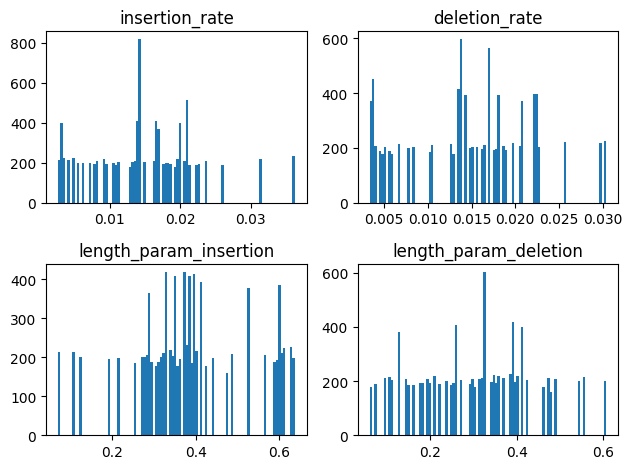

In [21]:
plt.subplot(221)
plt.hist(all_sims.insertion_rate, bins=100)
plt.title("insertion_rate")

plt.subplot(222)
plt.hist(all_sims.deletion_rate, bins=100)
plt.title("deletion_rate")

plt.subplot(223)
plt.hist(all_sims.length_param_insertion, bins=100)
plt.title("length_param_insertion")

plt.subplot(224)
plt.hist(all_sims.length_param_deletion, bins=100)
plt.title("length_param_deletion")

plt.tight_layout()

plt.show()

Tenericutes_3WUBT_geometric_SS_25
(-6.050000000000002, 149.05000000000004, 0.0, 919.8)


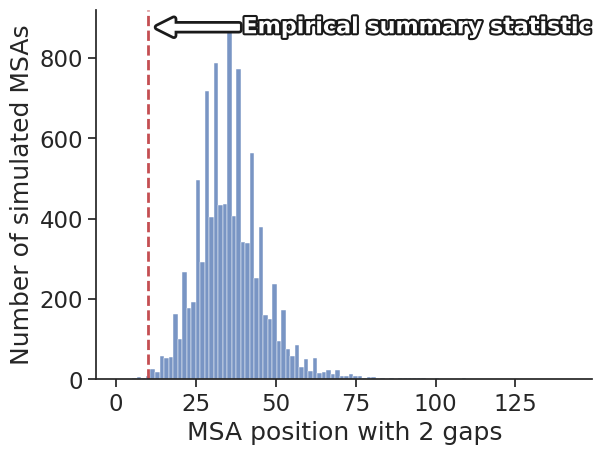

In [76]:
import matplotlib.patheffects as pe
sns.set(font_scale = 1.5)

sns.set_style("whitegrid")
sns.set_style("ticks")

selected_stat = "SS_25"
# all_sims[selected_stat].hist(bins=100)
print(f"{MAIN_PATH.stem}_{classification}_{selected_stat}")
sns.histplot(all_sims[selected_stat], bins=100)
plt.xlabel(prettify_stat(SUMSTATS_DEFINITION[selected_stat]))
plt.ylabel("Number of simulated MSAs")
plt.axvline(x=empirical_sum_stats[selected_stat], linewidth=2, color='r', linestyle='--')
xlim = plt.gca().get_xlim()[1]
ylim = plt.gca().get_ylim()[1]/1.05
plt.axis()
print(plt.axis())
plt.annotate("Empirical summary statistic",
             xy=(empirical_sum_stats[selected_stat] + 0.02*xlim, ylim), 
             xytext=(xlim, ylim),
             va='center', ha='right', color="white",
             arrowprops=dict(facecolor='white', 
                             path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()]),
             fontsize=16, fontweight=1000,
             path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
# plt.text(x=empirical_sum_stats[selected_stat]-50,y=300,s="$Empirical summary statisitic $")
sns.despine()
plt.savefig(f"{MAIN_PATH.stem}_{classification}_{selected_stat}.png",dpi=300, bbox_inches="tight")
# plt.show()

In [103]:
empirical_sum_stats[selected_stat]

0.0

In [21]:
datasets =  ["eggnog","yeast", "adequacy_sims"] # ["adequacy_sims",, "eggnog"]
datasets_str = "".join(datasets)

In [23]:
adequacy_data = {}
retained_summary_statistics_data = {}
retained_summary_statistics_data_corrected = {}

corrected = "corrected"
for current_data in datasets:
    # REMOTE_PATH = REMOTE_PATH.parent.resolve()
    CURRENT_REMOTE_PATH = RESULTS_PATH / current_data
    if not CURRENT_REMOTE_PATH.exists():
        exit(1)

    data_summary = {}
    retained_summary = {}
    retained_summary_corrected = {}

    for dataset_num, prot in enumerate(CURRENT_REMOTE_PATH.iterdir()):
        MAIN_PATH = prot
        TREE_PATH, MSA_PATH = fetch_paths(MAIN_PATH)

        try:
            model_params = raxml_parser.get_substitution_model(MAIN_PATH)
        except (ValueError, IndexError):
            model_params = {
                "inv_prop": -1,
                "gamma_shape": -1
            }

        
        tree = Phylo.read(TREE_PATH, 'newick')
        sum_branch_lengths = tree.total_branch_length()

        remote_emp_msa = Msa(str(MSA_PATH))
        empirical_sum_stats = remote_emp_msa.get_sum_stats()
        empirical_sum_stats = dict(zip(SUMSTATS_LIST, empirical_sum_stats))

        classification = get_classification(MAIN_PATH)
        print(classification)

        get_avg_gap = get_avg_gap(remote_emp_msa)

        ADEQUACY_FILES = MAIN_PATH / "adequacy_revised" 
        if not next(ADEQUACY_FILES.glob(f"{classification}_*.csv"), False):
            print(ADEQUACY_FILES)
            continue
        classification_sims = []

        for file_path in ADEQUACY_FILES.glob(f"{classification}_*.csv"):
            classification_sims.append(pd.read_csv(file_path).drop(columns="Unnamed: 0"))
        print(len(classification_sims))
        classification_sims = pd.concat(classification_sims)

        # classification_sims = pd.read_csv(ADEQUACY_FILES / f"{classification}_{corrected}.csv").drop(columns="Unnamed: 0")

        percentile_summary = get_percentile_summary(classification_sims, empirical_sum_stats)
        adequacy_score = sum(percentile_summary.retained)/len(percentile_summary)

        data_summary[prot.stem] = [get_avg_gap, classification, adequacy_score, sum_branch_lengths, model_params["inv_prop"], model_params["gamma_shape"]]
        retained_summary[prot.stem] = [classification, *get_retained_data(percentile_summary)]
        retained_summary_corrected[prot.stem] = [classification, *get_retained_data_corrected(percentile_summary)]

    adequacy_data[current_data] = pd.DataFrame(data_summary)
    adequacy_data[current_data] = adequacy_data[current_data].T.rename(columns={0:"max_gap", 
                                                                                1:"classification",
                                                                                2: "match_percent",
                                                                                3:"sum_branch_lengths",
                                                                                4: "inv_prop",
                                                                                5: "gamma_shape"})
    adequacy_data[current_data] = adequacy_data[current_data].astype({"max_gap": int,
                                                                      "match_percent": float,
                                                                      "sum_branch_lengths":float,
                                                                      "inv_prop": float,
                                                                      "gamma_shape": float})

    retained_summary_statistics_data[current_data] = retained_summary
    retained_summary_statistics_data_corrected[current_data] = retained_summary_corrected

with open(f"assets/adequacy_data_corrected_{datasets_str}.pickle", 'wb') as f:
    pickle.dump(file=f, obj=adequacy_data)
with open(f"assets/retained_summary_statistics_data_corrected_{datasets_str}.pickle", 'wb') as f:
    pickle.dump(file=f, obj=(retained_summary_statistics_data, retained_summary_statistics_data_corrected))
    

zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
geometric
100
zipf
100
zipf
100
zipf
100
poisson
100
poisson
100
zipf
100
zipf
100
geometric
100
poisson
100
zipf
100
zipf
100
poisson
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
geometric
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
poisson
100
poisson
100
zipf
100
geometric
100
zipf
100
zipf
100
poisson
100
zipf
100
zipf
100
zipf
100
zipf
100
poisson
100
zipf
100
geometric
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
poisson
100
zipf
100
geometric
100
zipf
100
zipf
100
zipf
100
zipf
100
zipf
100
geometric
100
zipf
100
poisson
100
zipf
100
zipf
100
zipf
100
zipf
100

In [22]:
with open(f"assets/adequacy_data_{datasets_str}.pickle", 'rb') as f:
    adequacy_data = pickle.load(f)
with open(f"assets/retained_summary_statistics_data_{datasets_str}.pickle", 'rb') as f:
    stats_data, stats_data_corrected = pickle.load(f)

In [93]:
lendist_mapper = {
    "zipf": "Zipf",
    "poisson": "Poisson",
    "geometric": "geometric"
}
lendist_colors = {
    "geometric":'navy',
    "Poisson":'crimson',
    "Zipf":'limegreen'
}

In [94]:
def get_retained_stats_df(retained_dict: dict, subset: list, dist_to_exclude=[]):
    retained_summary_statistics_df = pd.DataFrame(retained_dict)
    retained_summary_statistics_df = retained_summary_statistics_df.T
    retained_summary_statistics_df = retained_summary_statistics_df[subset]
    retained_summary_statistics_df.columns = ["classification", *SUMSTATS_LIST]

    group_nas_sum = retained_summary_statistics_df.set_index("classification").isna().groupby(level=0).sum()
    group_sizes = retained_summary_statistics_df.groupby("classification").size()
    group_num_datasets_minus_number_of_nas = ((-group_nas_sum).add(group_sizes.squeeze(), axis=0))

    statistics_summary_df = retained_summary_statistics_df.groupby("classification").sum() / group_num_datasets_minus_number_of_nas
    statistics_summary_df = statistics_summary_df.dropna(axis=1, how="all")

    sum_retained_df = retained_summary_statistics_df.groupby("classification").sum()[statistics_summary_df.columns]#.drop("poisson", axis=1)
    sum_retained_df = sum_retained_df.T.stack().reset_index()
    sum_retained_df = sum_retained_df.rename(columns={"level_0":"sum_stat",0:"datasets"})
    sum_retained_df = sum_retained_df.dropna()
    statistics_summary_df = statistics_summary_df.T.stack().reset_index()
    statistics_summary_df = statistics_summary_df.rename(columns={"level_0":"sum_stat",0:"pval_percent"})

    plot_df =  pd.merge(sum_retained_df, statistics_summary_df, how="inner")
    plot_df.sum_stat = plot_df.sum_stat.apply(lambda x: str(int(x.split("_")[1])+1))
    plot_df.classification = plot_df.classification.map(lendist_mapper)
    
    for lendist in dist_to_exclude:
        plot_df = plot_df[plot_df.classification != lendist]

    return plot_df

In [13]:
branch_length_filter = adequacy_data["eggnog"].sum_branch_lengths < 150
get_retained_stats_df(stats_data["eggnog"], branch_length_filter, ["Poisson"])
adequacy_data["eggnog"]["classification"].value_counts(normalize=True)["zipf"]

0.7596153846153846

In [14]:
eggnog_limits = (adequacy_data["eggnog"]["sum_branch_lengths"].min(),adequacy_data["eggnog"]["sum_branch_lengths"].max())
print(eggnog_limits)

(1.0026691194, 18.106845808499997)


<AxesSubplot: xlabel='sum_branch_lengths', ylabel='avg_gap'>

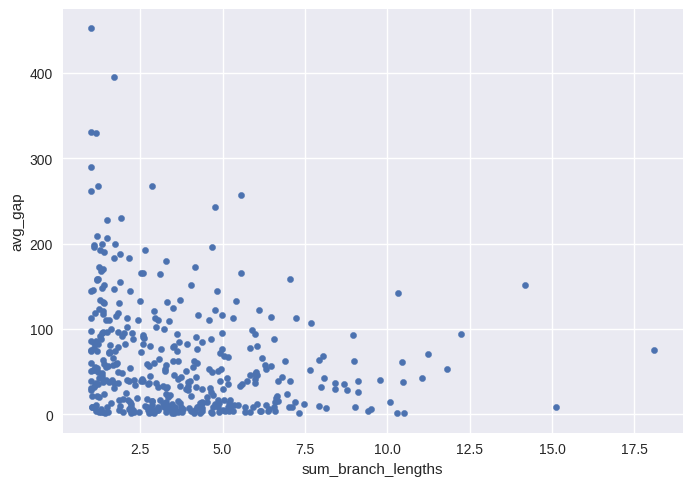

In [179]:
adequacy_data["eggnog"].plot(kind="scatter",x="sum_branch_lengths",y="avg_gap")

In [17]:
filterdf = adequacy_data["eggnog"].copy(deep=True)

In [168]:
filterdf["avg_gap"] = (filterdf["avg_gap"]-filterdf["avg_gap"].mean())/(filterdf["avg_gap"].std())

In [169]:
filterdf["sum_branch_lengths"] = (filterdf["sum_branch_lengths"]-filterdf["sum_branch_lengths"].mean())/(filterdf["sum_branch_lengths"].std())

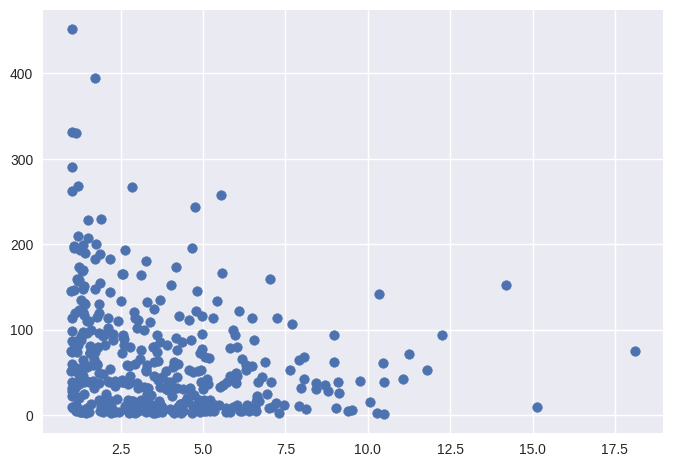

In [210]:
plt.scatter(filterdf["sum_branch_lengths"], filterdf["avg_gap"])

In [129]:
yeast_limits_bl = (adequacy_data["yeast"]["sum_branch_lengths"].min(),adequacy_data["yeast"]["sum_branch_lengths"].max())
yeast_limits_ag = (adequacy_data["yeast"]["avg_gap"].min(),adequacy_data["yeast"]["avg_gap"].max())

print(yeast_limits_bl)
print(yeast_limits_ag)

condition_bl = (adequacy_data["eggnog"].sum_branch_lengths > yeast_limits_bl[0]) & (adequacy_data["eggnog"].sum_branch_lengths < yeast_limits_bl[1])
condition_mg = (adequacy_data["eggnog"].avg_gap > yeast_limits_ag[0]) & (adequacy_data["eggnog"].avg_gap < yeast_limits_ag[1])
adequacy_data_eggnog_subset_bl = adequacy_data["eggnog"][condition_bl]
adequacy_data["eggnog_subset_bl"] = adequacy_data_eggnog_subset_bl
# adequacy_data_eggnog_subset_mg = adequacy_data["eggnog"][condition_mg]
# adequacy_data_eggnog_subset = adequacy_data["eggnog"][condition_bl & condition_mg]

# pd.merge(adequacy_data_eggnog_subset_bl, adequacy_data_eggnog_subset_mg, how="inner")
# adequacy_data["eggnog_subset"] = adequacy_data_eggnog_subset
# adequacy_data["eggnog_subset_mg"] = adequacy_data_eggnog_subset_mg
# adequacy_data["eggnog_subset_bl"] = adequacy_data_eggnog_subset_bl

(1.024588, 3.2040429999999995)
(1, 38)


In [180]:
adequacy_data["eggnog"]

,avg_gap,classification,match_percent,sum_branch_lengths,inv_prop,gamma_shape
Bacillus_1ZARG,93,zipf,0.814815,8.971458,0.334335,0.930439
Bacillus_1ZART,37,zipf,0.888889,8.421638,0.333222,1.003676
Bacillus_1ZAS4,35,zipf,0.925926,8.690216,0.302524,0.775725
Bacillus_1ZAXF,61,zipf,0.851852,10.457230,0.250521,0.902163
Bacillus_1ZAYH,4,zipf,0.962963,6.136563,0.200506,0.945354
...,...,...,...,...,...,...
Vibrionales_1XVEY,25,zipf,0.925926,2.059041,0.260473,1.761988
Vibrionales_1XVT4,94,zipf,0.888889,12.247243,0.034873,1.409799
Vibrionales_1XW2N,43,zipf,0.851852,1.263378,0.272052,1.534156
Vibrionales_1XW8K,8,geometric,1.000000,3.234361,0.088826,1.276559


In [181]:
adequacy_data["adequacy_sims"]

,avg_gap,classification,match_percent,sum_branch_lengths,inv_prop,gamma_shape
Bacillus_1ZARG_geometric_rim,4,geometric,1.000000,8.971458,0.334335,0.930439
Bacillus_1ZART_geometric_rim,7,geometric,1.000000,8.421638,0.333222,1.003676
Bacillus_1ZAS4_geometric_rim,10,geometric,0.962963,8.690216,0.302524,0.775725
Bacillus_1ZAXF_poisson_sim,14,poisson,1.000000,10.457230,0.250521,0.902163
Bacillus_1ZAYH_zipf_sim,0,zipf,1.000000,6.136563,0.200506,0.945354
...,...,...,...,...,...,...
Vibrionales_1XVEY_poisson_rim,32,poisson,1.000000,2.059041,0.260473,1.761988
Vibrionales_1XVT4_poisson_rim,13,poisson,1.000000,12.247243,0.034873,1.409799
Vibrionales_1XW2N_geometric_sim,1,geometric,1.000000,1.263378,0.272052,1.534156
Vibrionales_1XW8K_geometric_rim,2,geometric,1.000000,3.234361,0.088826,1.276559


In [24]:
am_hist_data = {
    "yeast": adequacy_data["yeast"].copy(deep=True),
    "eggnog": adequacy_data["eggnog"].copy(deep=True),
    # "eggnog_subset": adequacy_data_eggnog_subset_bl.copy(deep=True)
}

In [24]:
am_hist_data = {
    "adequacy_sims": adequacy_data["adequacy_sims"].copy(deep=True),

}

In [27]:
for val in am_hist_data.values():
    val["classification"] = val["classification"].map(lendist_mapper)

In [103]:
# lendist_colors = {
#     "geometric":'tab:blue',
#     "Poisson":'tab:red',
#     "Zipf":'tab:orange'
# }t


In [88]:
import matplotlib.patheffects as pe
sns.set(font_scale = 1.5)

sns.set_style("whitegrid")
sns.set_style("ticks")
def plot_data_hists(all_data, save_to):
    legend_elements = [Line2D([0], [0], path_effects=[pe.Stroke(linewidth=11, foreground='k'), pe.Normal()], color=x[1], lw=8, label=x[0], alpha=1.0) for x in lendist_colors.items()]

    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5))
    # fig.delaxes(ax[(1,1)])
    # fig.delaxes(ax[(1,0)])
    # ax[(1,1)].axis('off')
    # ax[(1,0)].axis('off')
    fig.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)

    positions_on_ax = [0,1]

    legend_pos = (0.5, -0.25)

    for title_label,pos,data in zip(['(a)','(b)'],positions_on_ax ,all_data):
        unique_labels = data.classification.unique()
        sns.histplot(data=data, x="match_percent", hue="classification",
                    multiple="dodge", shrink=0.8, legend=False,
                    element="bars", palette=lendist_colors, alpha=1.0,
                    binwidth=0.2, binrange=(0,1.0), edgecolor="k", linewidth=2,
                    ax=ax[pos])

        ax[pos].set_xlabel("AM score", size=18, labelpad=10)
        if pos == 0:
            ax[pos].set_ylabel("Number of datasets", size=18, labelpad=10)
        else:
            ax[pos].set_ylabel("")
        ax[pos].set_title(label=title_label, loc="left")
        ax[pos].set_xticks(np.arange(0,1.1,0.2))
        ax[pos].set_xlim(0,1.0)

    unique_labels = {l:i for i,l in enumerate(unique_labels)}
    color_indexes = {l:i for i,l in enumerate(lendist_colors.keys())}

    mapping_to_colors = [color_indexes[l] for l in unique_labels.keys()]
    legend_elements = [legend_elements[i] for i in mapping_to_colors]
    
    fig.legend(handles=legend_elements,
               loc='lower center', 
               fontsize=16, title="Classification", title_fontsize=24, ncol=3,
               edgecolor="white",
               bbox_to_anchor=legend_pos)
    sns.despine()

    # sns.move_legend(ax[legend_origin], loc="upper left", bbox_to_anchor=(1.5, -0.5), title='Classification')
    # fig.tight_layout()
    if save_to.exists():
        plt.savefig(save_to / f"adequacy_hist.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()
    else:
        plt.show()

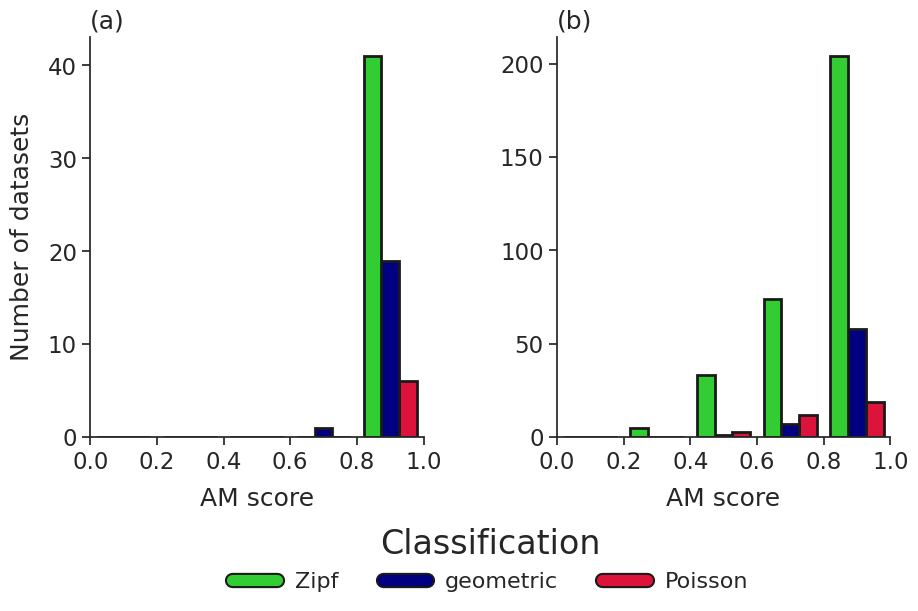

In [89]:
assets_folder = pathlib.Path("./assets")

plot_data_hists(am_hist_data.values(), assets_folder)

In [193]:
for dataset in ["adequacy_sims"]: 
    for lendist in length_distributions:
        temp_df = adequacy_data[dataset][adequacy_data[dataset].classification == lendist]
        print(f"{dataset} {lendist} mean AM is {temp_df.match_percent.mean()}")


adequacy_sims zipf mean AM is 0.9787994891443167
adequacy_sims geometric mean AM is 0.9708369787109944
adequacy_sims poisson mean AM is 0.9832387131657204


In [194]:
for dataset in ["yeast","eggnog"]: 
    for lendist in length_distributions:
        temp_df = adequacy_data[dataset][adequacy_data[dataset].classification == lendist]
        print(f"{dataset} {lendist} mean AM is {temp_df.match_percent.mean()}")

print(stats.ttest_ind(adequacy_data["eggnog"].match_percent, adequacy_data["yeast"].match_percent))

yeast zipf mean AM is 0.960252935862692
yeast geometric mean AM is 0.975925925925926
yeast poisson mean AM is 0.9320987654320989
eggnog zipf mean AM is 0.8104781997187059
eggnog geometric mean AM is 0.9214365881032547
eggnog poisson mean AM is 0.8202614379084966
Ttest_indResult(statistic=-7.175549532967399, pvalue=2.742773701096115e-12)


In [195]:
#  differences in the mean AM scores between the datasets that were classified as Zipf and those classified as geometric in the EggNOG dataset
eggnog_adequacy_data = adequacy_data["eggnog"]
stats.ttest_ind(eggnog_adequacy_data[eggnog_adequacy_data.classification == "zipf"].match_percent,
                eggnog_adequacy_data[eggnog_adequacy_data.classification == "geometric"].match_percent)

Ttest_indResult(statistic=-5.568237932986776, pvalue=4.8739454860350326e-08)

In [196]:
yeast_adequacy_data = adequacy_data["yeast"]
stats.ttest_ind(yeast_adequacy_data[yeast_adequacy_data.classification == "zipf"].match_percent,
                yeast_adequacy_data[yeast_adequacy_data.classification == "geometric"].match_percent)

Ttest_indResult(statistic=-1.172382688820454, pvalue=0.24575556902859008)

In [198]:
stats.ttest_ind(yeast_adequacy_data[yeast_adequacy_data.classification == "zipf"].match_percent,
                eggnog_adequacy_data[eggnog_adequacy_data.classification == "zipf"].match_percent)

Ttest_indResult(statistic=6.143903925454511, pvalue=2.161456609437369e-09)

In [199]:
stats.ttest_ind(yeast_adequacy_data[yeast_adequacy_data.classification == "geometric"].match_percent,
                eggnog_adequacy_data[eggnog_adequacy_data.classification == "geometric"].match_percent)

Ttest_indResult(statistic=2.299897021927148, pvalue=0.023934475569963955)

In [200]:
# yeast_adequacy_data[yeast_adequacy_data.classification == "geometric"].match_percent.mean()
eggnog_adequacy_data[eggnog_adequacy_data.classification == "geometric"].match_percent.mean()

0.9214365881032547

In [201]:
label_size = 36
def plot_reg(x_list, y, dataset, data: pd.DataFrame, save_assets: pathlib.Path):
    props = dict(boxstyle='round', facecolor='wheat', alpha=1.0)
    for x in x_list:
        r_val, p_val = stats.pearsonr(data[x], data[y])
        sns.lmplot(x=x, y=y, data=data)
        ax = plt.gca()
        plt.ylabel("AM score", size=label_size//2)
        plt.xlabel("Average unique gaps size", size=label_size//2)
        ax.text(0.8,0.9,f"R={r_val:.3f}\np={p_val:.1e}", fontsize=12, transform=ax.transAxes, bbox=props)
        
        if save_assets.exists():
            plt.savefig(save_assets / f"{x}_{y}_{dataset}.png", dpi=300, bbox_inches="tight")
            plt.show()
            plt.close()
        else:
            plt.show()

    # fig, ax = plt.subplots(figsize=(10, 10))

    # sns.histplot(data=data, x=y, hue="classification", element="step", legend = False, ax=ax)
    # plt.xlabel("AM score", size=label_size)
    # plt.ylabel("Number of datasets", size=label_size)
    # plt.xticks(fontsize=label_size-4)
    # plt.yticks(fontsize=label_size-4)
    # if save_assets.exists():
    #     plt.savefig(save_assets / f"{y}_{dataset}_hist.svg", dpi=200)
    #     plt.show()
    #     plt.close()
    # else:
    #     plt.show()
    
    data.groupby(by="classification").describe()[["match_percent","sum_branch_lengths"]].to_csv(save_assets / "summary.csv")

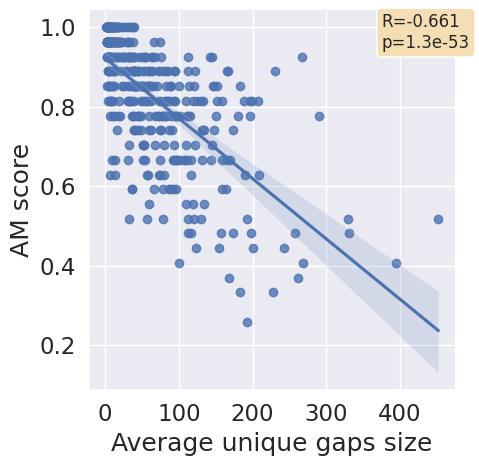

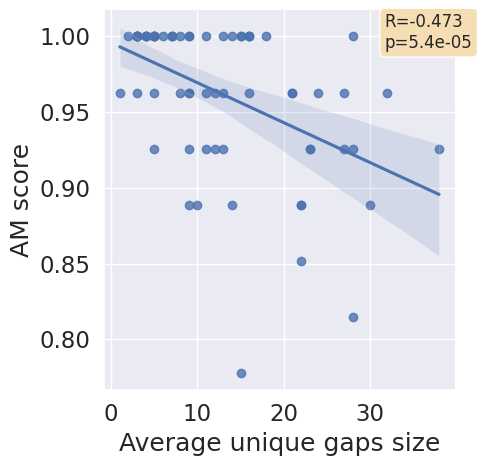

In [235]:
# assets_folder = pathlib.Path("/home/elyalab/Documents/Phd/length distributions/assets/adequacy")

# for dataset in ["eggnog","yeast","eggnog_subset", "eggnog_subset_mg", "eggnog_subset_bl"]:
for dataset in ["eggnog","yeast"]:
    assets_folder = pathlib.Path("./assets")
    # assets_folder = assets_folder / dataset
    plot_reg(["avg_gap"], "match_percent", dataset, adequacy_data[dataset], assets_folder)

In [195]:
list(product(length_distributions, ["eggnog","yeast"]))

[('zipf', 'eggnog'),
 ('zipf', 'yeast'),
 ('geometric', 'eggnog'),
 ('geometric', 'yeast'),
 ('poisson', 'eggnog'),
 ('poisson', 'yeast')]

In [203]:
dist_frac = {(lendist, database): 0 for lendist, database in product(length_distributions, ["eggnog","yeast"])}
for lendist, database in dist_frac.keys():
    print(lendist, database)
    temp_df = adequacy_data[database][adequacy_data[database].classification == lendist]
    dist_frac[(lendist, database)] = (temp_df.match_percent.values)

stats.ttest_ind(dist_frac[("zipf","yeast")], dist_frac[("zipf","eggnog")]).pvalue

zipf eggnog
zipf yeast
geometric eggnog
geometric yeast
poisson eggnog
poisson yeast


2.161456609437369e-09

In [204]:
current_data = "eggnog"
inv_prop_data = adequacy_data[current_data][adequacy_data[current_data].inv_prop >= 0]
print(stats.pearsonr(inv_prop_data.inv_prop,inv_prop_data.match_percent))
# plt.scatter(inv_prop_data.inv_prop, inv_prop_data.match_percent)
# plt.show()

PearsonRResult(statistic=-0.09586796795760222, pvalue=0.051552891278830254)


In [206]:
gamma_data = adequacy_data[current_data][adequacy_data[current_data].gamma_shape < 200]
gamma_data = gamma_data[gamma_data.gamma_shape >= 0]

print(stats.pearsonr(gamma_data.gamma_shape,gamma_data.match_percent))
# plt.scatter(gamma_data.gamma_shape, gamma_data.match_percent)
# plt.show()

PearsonRResult(statistic=-0.06367484617156473, pvalue=0.1965599511291745)


In [106]:
def plot_retained_stats(stats_df: pd.DataFrame, plot_name: str, title: str, axes: plt.Axes):
    
    # markers_style = ['o', '*']
    markers_style = ['o','X','*'] 

    # marker_sizes = [150, 400]
    marker_sizes = [150, 100, 400]


    for idx, val in enumerate(stats_df.classification.unique()):
        current_df = stats_df[stats_df.classification == val]
        # plt.subplot(2,1,idx+1)
        axes.scatter(current_df["sum_stat"],
                 current_df["pval_percent"],
                 s=marker_sizes[idx], marker=markers_style[idx], edgecolors='k', linewidths=1, alpha=0.8,
                 color=lendist_colors[val], label=val)
    
    axes.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if title is not None:
      axes.set_title(label=title, loc="left", fontsize=22, pad=10)
    if title == "(b)":
        axes.tick_params(axis='x', labelsize=20, which="major", direction="out", width=2, length=5, color='gray')
    else:
        axes.tick_params(axis='x', labelsize=20, which="major", direction="out", width=0, length=0, color='k')

    axes.set_ylabel("Percentage of datasets", size=24, labelpad=10)
    axes.tick_params(axis='y', labelsize=20, which="major", direction="out", width=3, length=5, color='k')

    # axes.set_ylim(0.0,1.05)
    # axes.set_ylim(0.89,1.01)

      # plt.ylabel("Percentage of datasets", size=16)
    # plt.xlabel("Summary statistics", size = 18, labelpad=10)

    # plt.ylim(0.0,1.05)
    # return plt.gca()
    # plt.savefig(f"{plot_name}_retained_summary.svg" ,dpi=200, bbox_inches="tight")

    # plt.show()


[('adequacy_sims', [])]


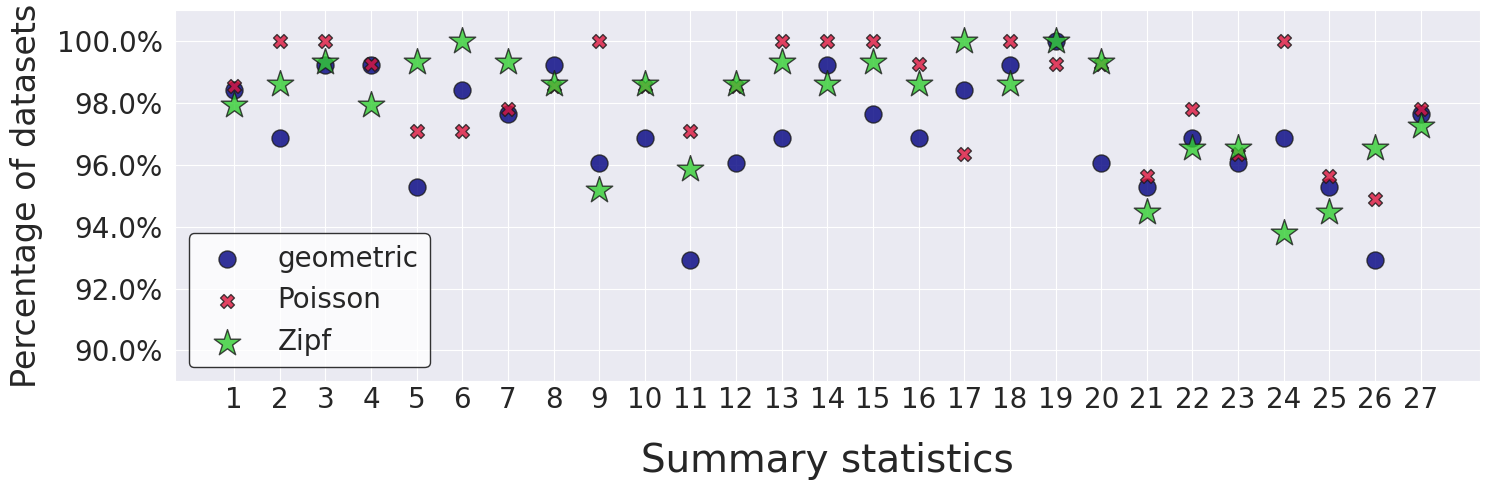

In [107]:
sns.reset_defaults()
sns.set_style("darkgrid")
sns.set_style(rc={
    'xtick.bottom': True
})
plot_list = [("adequacy_sims", [])]
            #  ("yeast", ["Poisson"]),
            #  ("eggnog", ["Poisson"])]#,
            #  ("sims_corrected", []),
            #  ("sims_not_corrected", [])]
print(plot_list)
fig, axes_list = plt.subplots(nrows=len(plot_list), sharex=True)
axes_list = [axes_list]
fig.set_size_inches(15,5 * len(plot_list))
titles = []
# titles = {0:"(a)", 1:"(b)"}
for idx, (dataset, lendist_list) in enumerate(plot_list):
    branch_length_filter = adequacy_data[dataset].sum_branch_lengths < 150
    stats_df = get_retained_stats_df(stats_data[dataset], 
                                     branch_length_filter,
                                     dist_to_exclude=lendist_list)

    # temp_np = stats_df["pval_percent"].to_numpy()
    # temp_np = temp_np[::2] <= temp_np[1::2] # is yeast pval smaller than eggnog
    # temp_np = np.arange(0,27)[temp_np]
    # print(temp_np, len(temp_np)) # print sum stats for which it is the case and how many
    plot_retained_stats(stats_df, dataset, title=titles[idx] if len(plot_list) > 1 else None  ,axes=axes_list[idx])
plt.xlabel("Summary statistics", size = 28, labelpad=20)

legend = axes_list[0].legend(frameon = 1, fontsize=20)

frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
fig.tight_layout()
plt.savefig("assets/all_retained_summary.png" ,dpi=300, bbox_inches="tight")

plt.show()

In [241]:
# percentage of retention with Bonferroni:
for d in datasets:
    stats_summary = pd.DataFrame(stats_data_corrected[d]).T
    number_of_retentions = stats_summary.loc[:,1:].all(axis=1).sum()
    percent_retention = number_of_retentions/len(stats_summary)
    print(f"{d}: {percent_retention:.1%} with Bonferroni")

print()
# percentage of retention without Bonferroni:
for d in datasets:
    stats_summary = pd.DataFrame(stats_data[d]).T
    number_of_retentions = stats_summary.loc[:,1:].all(axis=1).sum()
    percent_retention = number_of_retentions/len(stats_summary)
    print(f"{d}: {percent_retention:.1%} without Bonferroni")


eggnog: 41.1% with Bonferroni
yeast: 89.6% with Bonferroni
adequacy_sims: 97.8% with Bonferroni

eggnog: 13.5% without Bonferroni
yeast: 49.3% without Bonferroni
adequacy_sims: 76.0% without Bonferroni


In [272]:
match_filter = adequacy_data["yeast"]
match_filter.classification.value_counts(normalize=True)

zipf         0.611940
geometric    0.298507
poisson      0.089552
Name: classification, dtype: float64

In [243]:
match_filter = adequacy_data["eggnog"][adequacy_data["eggnog"].match_percent >= 0.8]
match_filter.classification.value_counts(normalize=True)

zipf         0.725979
geometric    0.206406
poisson      0.067616
Name: classification, dtype: float64

In [273]:
match_filter_counts = match_filter.classification.value_counts()

In [274]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.set_style("ticks")

match_filter_counts.plot(kind="bar", ax=ax, legend=False, edgecolor="k", lw=3)
labels = [l.title() for l in match_filter_counts.index]

plt.yticks(size=24)
plt.xticks(ax.get_xticks(),labels=labels, rotation=0, fontdict={
    'size': 28,
    'weight': 600
})

plt.ylabel("Number of datasets", labelpad=10, fontdict={
    'size': 28,
    'weight': 500
})
plt.xlabel("Length distribution", size=32, labelpad=20)
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', size=24)

sns.despine()
plt.savefig(f"../abc/assets/yeast_hist_corrected.png", bbox_inches="tight", dpi=300)


In [326]:
match_filter = adequacy_data["eggnog"][adequacy_data["eggnog"].avg_gap < 10]
match_filter.classification.value_counts(normalize=True)

geometric    0.568421
zipf         0.326316
poisson      0.105263
Name: classification, dtype: float64

In [312]:
stats_summary

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
seqal_chrII_332874-333384_+_YBR048W,zipf,1,1,1,0,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,0
seqal_chrII_393176-393505_+_YBR078W,geometric,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
seqal_chrII_60190-60693_-_YBL087C,zipf,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,0,0,1,1
seqal_chrII_604510-604922_+_YBR189W,zipf,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
seqal_chrII_606276-606663_+_YBR191W,zipf,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seqal_chrXVI_282140-282664_+_YPL143W,geometric,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
seqal_chrXVI_377993-378386_-_YPL090C,geometric,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
seqal_chrXVI_406644-407064_+_YPL079W,geometric,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
seqal_chrXVI_654165-654567_+_YPR043W,zipf,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [286]:

stats_summary = pd.DataFrame(stats_data["eggnog"]).T
match_filter = stats_summary[stats_summary[0] == "zipf"]
# match_filter = match_filter[adequacy_data["eggnog"].avg_gap < 10]
match_filter.loc[:,1:].sum(axis=1).nsmallest(10)

Primates_4MHEJ          7.0
Drosophilidea_45SEE     9.0
Rhabditida_40V2M        9.0
Brassicales_3HVZ5      10.0
Primates_4MRKW         10.0
Ciliophora_3ZD1H       11.0
Primates_4MCXB         11.0
Primates_4MM0D         11.0
Primates_4M8W8         12.0
Primates_4MH05         12.0
dtype: float64

In [288]:
len(match_filter.loc[:,1:])

316

In [289]:
(match_filter.loc[:,1:].sum(axis=0) / len(match_filter.loc[:,1:]))*100

1     57.594937
2     95.886076
3      81.64557
4     66.139241
5     73.101266
6     92.088608
7     91.772152
8     87.658228
9     68.037975
10    30.379747
11     77.21519
12    86.075949
13     95.56962
14    97.151899
15    88.924051
16    95.886076
17    99.367089
18    91.139241
19     95.56962
20    99.683544
21    76.898734
22    87.025316
23    87.974684
24    53.481013
25    57.594937
26    71.202532
27    83.227848
dtype: object

In [58]:
REMOTE_PATH = RESULTS_PATH / "eggnog"

In [60]:
SS_2_list = []
SS_3_list = []

for i in stats_summary.index:
    MAIN_PATH = REMOTE_PATH / i

    if not MAIN_PATH.exists():
        print("Did not load data")
        raise FileNotFoundError(MAIN_PATH)

    TREE_PATH = None
    MSA_PATH = None

    if len( n := list(MAIN_PATH.glob("*.fasta"))) == 1:
        MSA_PATH = n[0]

    if MSA_PATH is None:
        print("no fasta or tree file")
        exit()

    empirical_msa = Msa(str(MSA_PATH))
    empirical_sum_stats = empirical_msa.get_sum_stats()
    SS_2_list.append(empirical_sum_stats[2])
    SS_3_list.append(empirical_sum_stats[3])



In [65]:
adequacy_data["eggnog"]["max_seq_len"] = SS_2_list
adequacy_data["eggnog"]["min_seq_len"] = SS_3_list

In [67]:
adequacy_data["eggnog"]["seq_len_ratio"] = adequacy_data["eggnog"]["max_seq_len"] / adequacy_data["eggnog"]["min_seq_len"]

PearsonRResult(statistic=-0.6611178369788216, pvalue=1.3017838569050713e-53)

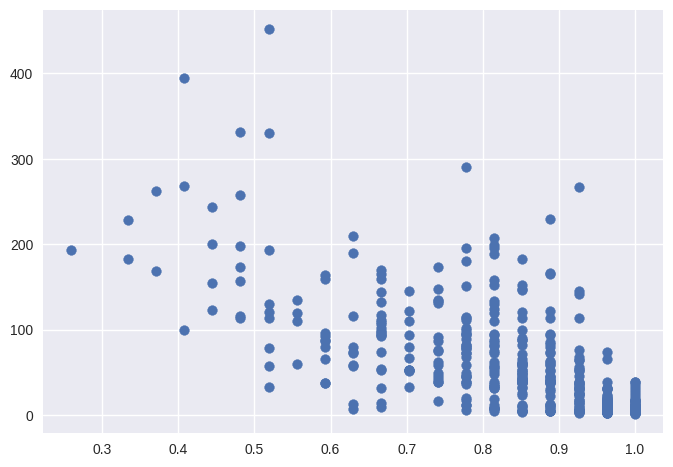

In [207]:
plt.scatter(x=adequacy_data["eggnog"]["match_percent"] ,y=adequacy_data["eggnog"]["avg_gap"])
stats.pearsonr(x=adequacy_data["eggnog"]["match_percent"] ,y=adequacy_data["eggnog"]["avg_gap"])

PearsonRResult(statistic=-0.47256709596908025, pvalue=5.394987631578342e-05)

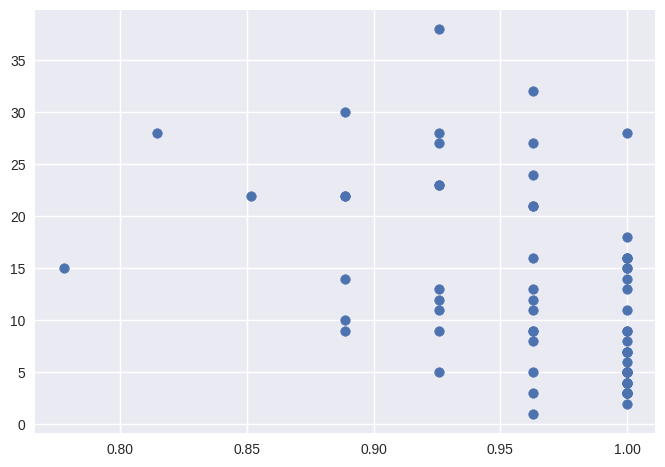

In [279]:
plt.scatter(x=adequacy_data["yeast"]["match_percent"] ,y=adequacy_data["yeast"]["avg_gap"])
stats.pearsonr(x=adequacy_data["yeast"]["match_percent"] ,y=adequacy_data["yeast"]["avg_gap"])

PearsonRResult(statistic=-0.6710833560155512, pvalue=1.0420145036861068e-42)

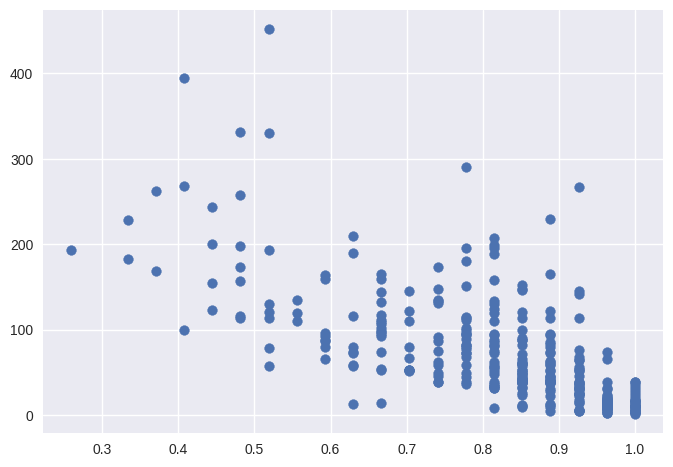

In [287]:
match_filter = adequacy_data["eggnog"]
match_filter = match_filter[match_filter.classification == "zipf"]
# match_filter = match_filter[match_filter.match_percent < 0.8]
# match_filter = match_filter[match_filter.avg_gap > 20]
match_filter.classification.value_counts()

plt.scatter(x=match_filter["match_percent"] ,y=match_filter["avg_gap"])
stats.pearsonr(x=match_filter["match_percent"] ,y=match_filter["avg_gap"])

In [289]:
species_list = list(stats_summary.index)

In [56]:
sims_data = adequacy_data["adequacy_sims"]
eggnog_data = adequacy_data["eggnog"]

In [57]:
sims_data.index = sims_data.reset_index()["index"].apply(lambda x: x.rsplit("_", maxsplit=2)[0])

In [65]:
prots_eggnog = set(eggnog_data[eggnog_data.classification == "zipf"].index)
prots_sims = set(sims_data[sims_data.classification == "zipf"].index)

intersection_of_data =  prots_sims.intersection(prots_eggnog)
len(intersection_of_data)

125

In [61]:
eggnog_data_subset = eggnog_data[[i in intersection_of_data  for i in eggnog_data.index]]
eggnog_data_subset = eggnog_data_subset.sort_index()
sims_data_subset = sims_data[[i in intersection_of_data  for i in sims_data.index]]
sims_data_subset = sims_data_subset.sort_index()

In [66]:
print(intersection_of_data)

{'Rhabditida_40S9H', 'Rodentia_4PS96', 'Drosophilidea_45WKQ', 'Brassicales_3HTDJ', 'Bacillus_1ZCEM', 'Rhabditida_40SFX', 'Ciliophora_3ZB2Z', 'Paeruginosa_1YFMH', 'Vibrionales_1XUQD', 'Rodentia_4Q1G6', 'Primates_4ME23', 'Vibrionales_1XUB6', 'Brassicales_3HQ7D', 'Saccharomycetaceae_3S0RA', 'Primates_4MRKW', 'Rodentia_4Q41X', 'Saccharomycetaceae_3RZRX', 'Drosophilidea_45SEE', 'Rodentia_4PTS1', 'Tenericutes_3WT72', 'Chlorophyta_34HB2', 'Drosophilidea_45SSP', 'Rhabditida_40TFR', 'Escherichia_3XNH1', 'Brassicales_3HWPW', 'Brassicales_3HWED', 'Staphylococcaceae_4GXGU', 'Drosophilidea_45QQ6', 'Vibrionales_1XTG6', 'Saccharomycetaceae_3RZN1', 'Chlorophyta_34GX2', 'Primates_4MINA', 'Staphylococcaceae_4GXH0', 'Rodentia_4PVTR', 'Brassicales_3HSQP', 'Rodentia_4PY68', 'Rodentia_4PTGV', 'Drosophilidea_45WV7', 'Paeruginosa_1YE0S', 'Ciliophora_3ZB07', 'Escherichia_3XNKI', 'Brassicales_3HXGM', 'Escherichia_3XN02', 'Tenericutes_3WU9V', 'Drosophilidea_45RS0', 'Brassicales_3HZN3', 'Rodentia_4PSEZ', 'Drosoph